In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'HFRXGL'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [6]:
prices_all = bnp.join(risk_premia,how="inner").ffill().join(hfrx,how="inner")
prices_all.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA,HFRXGL
2007-01-03,251.659037,221.446381,123.569027,122.453216,213.419777,187.351929,143.396494,295.276204,289.6684,214.633123,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.139360
2007-01-04,250.891929,221.752767,124.485468,116.840530,212.022884,186.812785,142.625314,294.978808,285.5191,215.297053,...,0.996090,0.995580,0.997660,1.001242,1.000243,0.996902,1.000146,NaN,NaN,1.138254
2007-01-05,247.941926,220.296431,122.435019,116.354951,210.202422,184.800752,141.220705,294.559578,283.5307,211.436575,...,1.000518,1.000001,0.996420,0.999333,0.999586,0.998485,0.989704,NaN,NaN,1.133457
2007-01-08,247.619806,220.849207,122.435019,114.489675,209.896589,184.914022,140.466947,292.889470,280.1748,211.660237,...,1.005248,1.002365,0.997761,1.000212,0.998146,0.996573,0.988449,NaN,NaN,1.132923
2007-01-09,247.980535,220.738811,123.630465,112.996176,210.556213,185.164783,140.518570,293.917702,281.4930,211.994064,...,1.005052,1.002498,0.999367,1.001821,0.995801,0.994901,0.988940,NaN,NaN,1.133387


In [7]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()

In [8]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of HFRXGL returns : 0.21306283107209079
Auto-correlation of HFRXGL adjusted returns : -0.004557305113453535


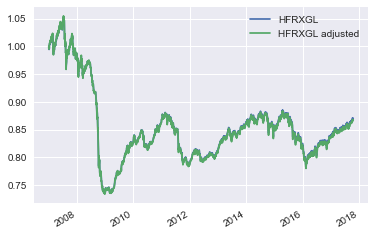

In [9]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

## Estimation of the exposures

In [10]:
size = 126
freq = 5

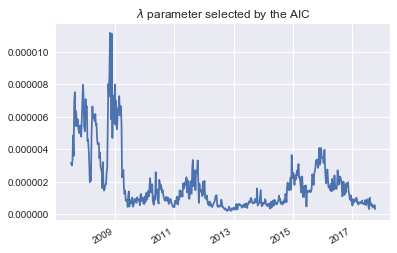

Wall time: 39.1 s


In [11]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:]

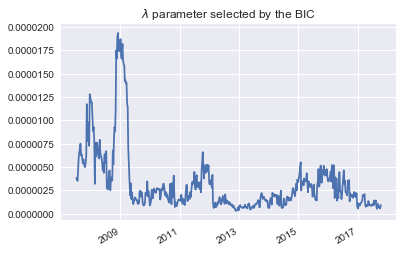

Wall time: 36.5 s


In [12]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:]

In [13]:
%%time
nu = 1.0
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 247 ms


In [14]:
%%time
tau = 0.1
freq_ml = 20
df_weight_ml_kalman, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau)

Wall time: 9.8 s


In [15]:
%%time
df_weight_kalman_bic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 37.4 s


In [54]:
%%time
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic')

prices_for_track_ml_kalman_bic = prices_all.loc[df_weight_ml_kalman_bic.index[0]:]

Wall time: 24.5 s


In [16]:
%%time
df_weight_kalman_aic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 37.6 s


In [55]:
%%time
df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic')

prices_for_track_ml_kalman_aic = prices_all.loc[df_weight_ml_kalman_aic.index[0]:]

Wall time: 14.8 s


## Replication

In [56]:
%%time
tc = 0.0005
lag = 3

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = hfrx.loc[replication_aic.index]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_ml_kalman = make_track(prices_for_track_kalman, df_weight_ml_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman"] = replication_ml_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_ml_kalman_aic = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman AIC"] = replication_ml_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

replication_ml_kalman_bic = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman BIC"] = replication_ml_kalman_bic

Wall time: 1.44 s


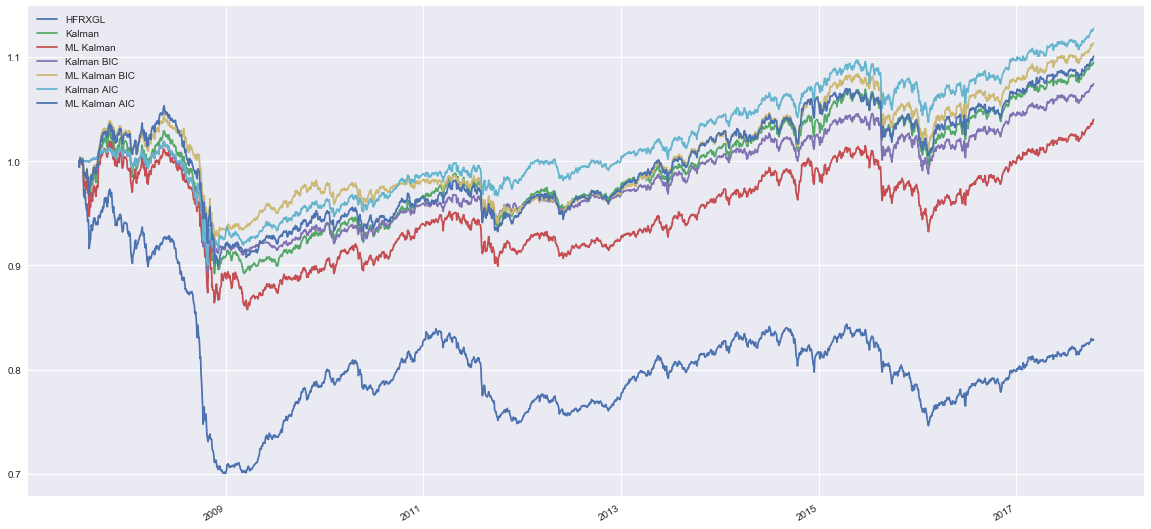

In [58]:
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', "ML Kalman BIC", 'Kalman AIC', "ML Kalman AIC"]].plot(figsize=(20,10))

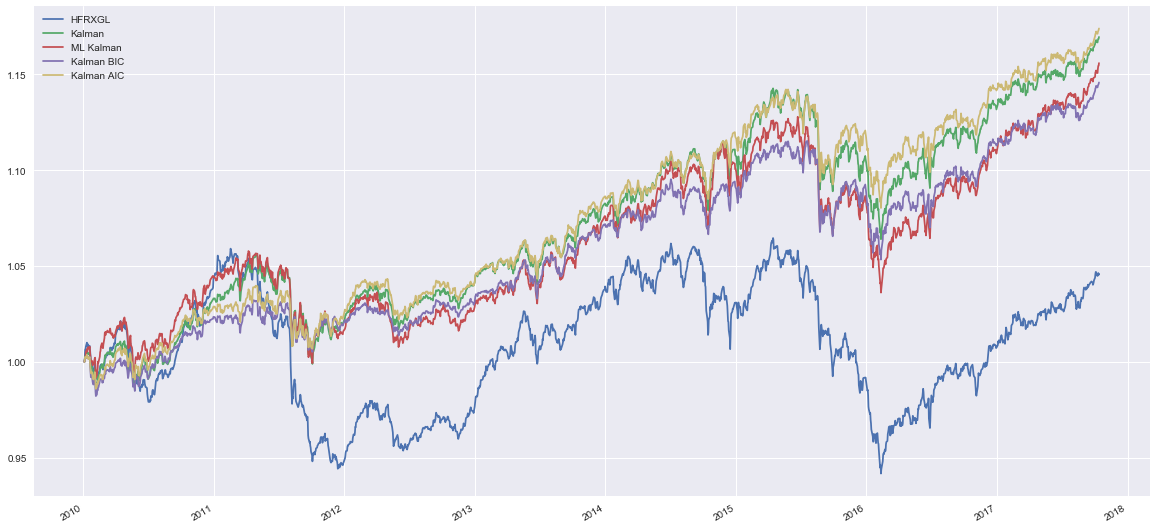

In [59]:
temp = df_res.loc['2010':]
temp = (temp / temp.iloc[0])
temp[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [60]:
df_stat = replication_stats(df_res, fund_name=fund_name)
df_stat

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.446256,-0.018432,1.000000,1.000000
Lasso AIC,0.001466,0.659844,0.263629,0.007462,0.814960,0.608424
Lasso BIC,0.001576,0.607319,0.133597,0.003068,0.795747,0.589601
Kalman,0.001392,0.693522,0.261716,0.008992,0.837115,0.628076
ML Kalman,0.001718,0.533211,0.115298,0.003885,0.772521,0.583043
Kalman AIC,0.001591,0.599621,0.377372,0.011919,0.775775,0.594762
ML Kalman AIC,0.001572,0.609336,0.279984,0.009524,0.789440,0.595827
Kalman BIC,0.001645,0.572065,0.237254,0.007107,0.757664,0.570576
ML Kalman BIC,0.001540,0.625031,0.314971,0.010664,0.796661,0.594532


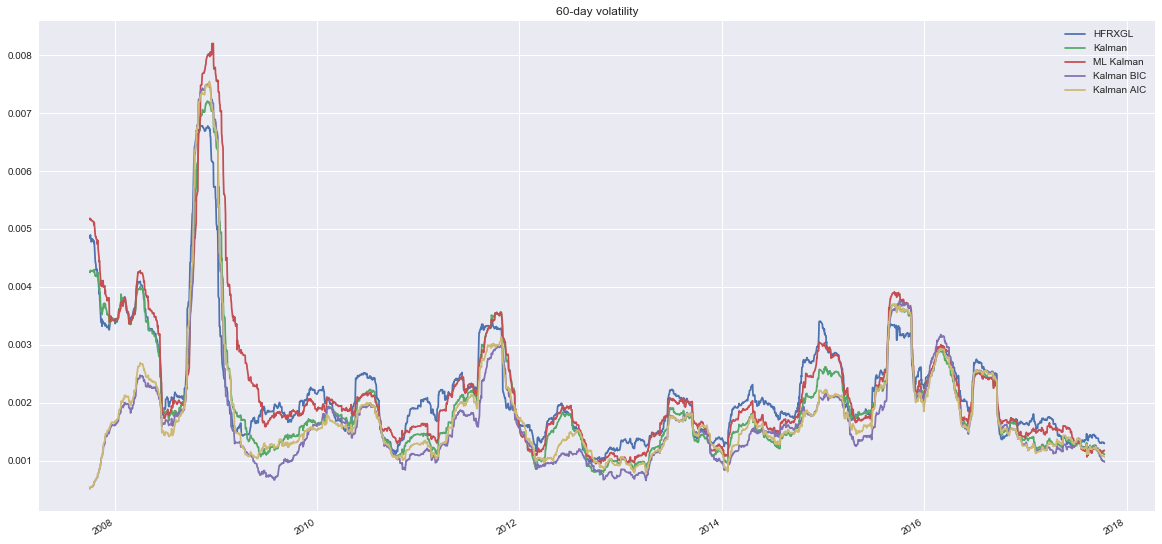

In [21]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
vol[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10), title='60-day volatility')

### Volatility adjustment

In [50]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=size)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=size)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=size)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True, vol_period=size)

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

Wall time: 1min 39s


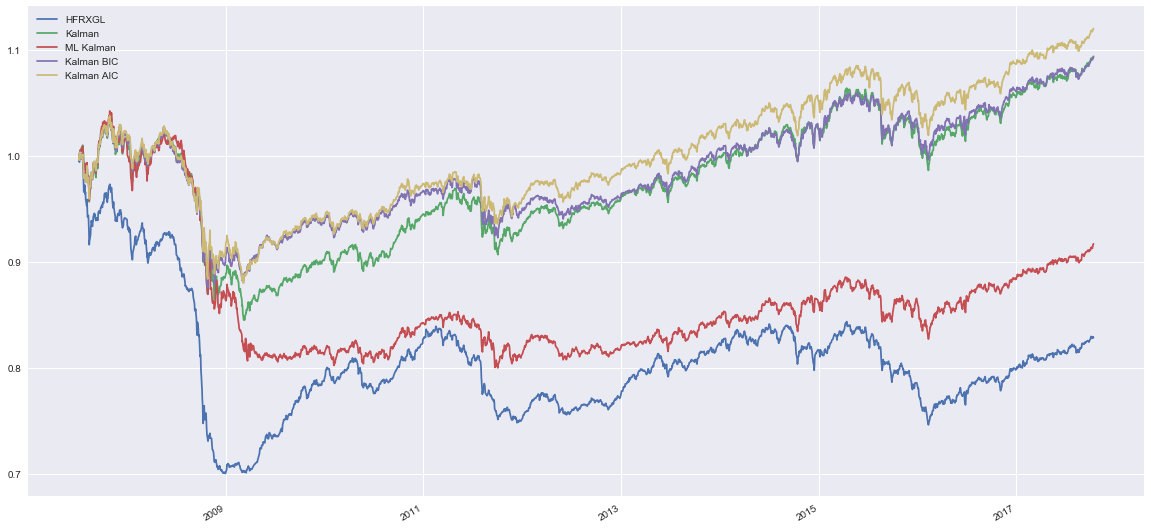

In [51]:
df_res_voladj = df_res_voladj.dropna()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj.plot(figsize=(20,10))

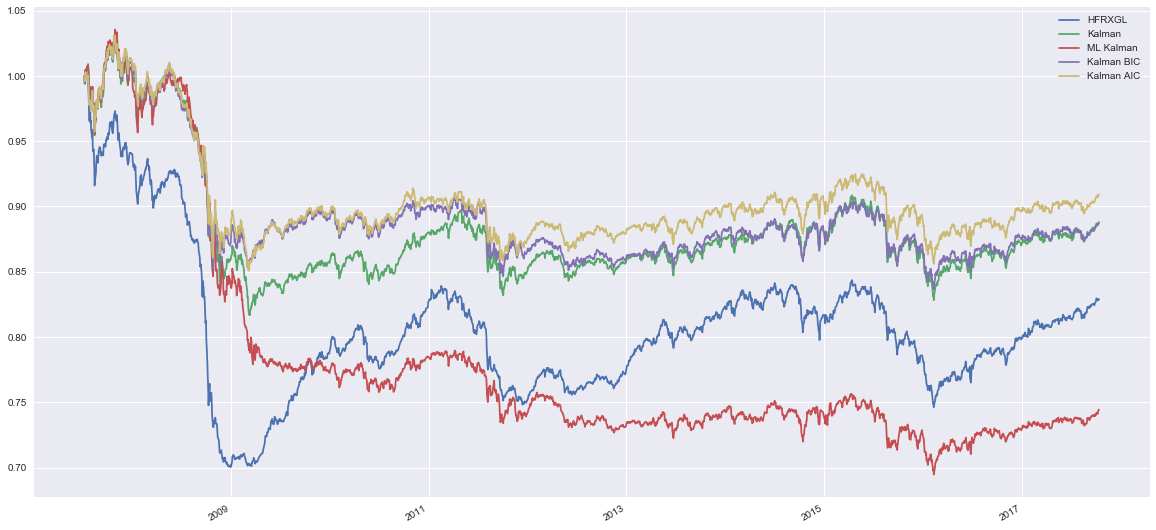

In [52]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10))

## Statistics on replication

In [25]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.446256,-0.018432,1.000000,1.000000
Kalman AIC,0.001650,0.569574,0.282457,0.011275,0.802872,0.604030
Kalman BIC,0.001718,0.533009,0.223730,0.008840,0.790166,0.583020
Kalman,0.001586,0.601960,0.227577,0.008904,0.818279,0.621254
ML Kalman,0.002002,0.366119,-0.162733,-0.008553,0.737170,0.539915


## Volatility contributions

In [26]:
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_vol_contrib_kalman_bic_voladj = (prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).std()
df_vol_contrib_kalman_bic_voladj = df_vol_contrib_kalman_bic_voladj/df_vol_contrib_kalman_bic_voladj.sum()

df_vol_contrib_kalman_aic_voladj = (prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).std()
df_vol_contrib_kalman_aic_voladj = df_vol_contrib_kalman_aic_voladj/df_vol_contrib_kalman_aic_voladj.sum()

In [27]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman BIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC"] = df_vol_contrib_kalman_aic_voladj
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [28]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [29]:
g = hc_spiderweb(df_vol_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [30]:
g = hc_spiderweb(df_vol_contrib_style, title="Vol contribution by Style")
g.plot()

In [31]:
g = hc_piechart(df_vol_contrib_asset_class[["Kalman BIC"]], title="Vol contribution by Asset Class in Kalman BIC")
g.plot()

In [32]:
g = hc_piechart(df_vol_contrib_style[["Kalman BIC"]], title="Vol contribution by Style in Kalman BIC")
g.plot()

## Performance contributions

In [33]:
df_perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).prod() - 1

df_perf_contrib_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).prod() - 1

df_perf_contrib_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).prod() - 1

In [34]:
df_perf_contrib = pd.DataFrame()
df_perf_contrib["Kalman"] = df_perf_contrib_kalman_voladj
df_perf_contrib["Kalman BIC"] = df_perf_contrib_kalman_bic_voladj
df_perf_contrib["Kalman AIC"] = df_perf_contrib_kalman_aic_voladj
df_perf_contrib = df_perf_contrib.join(df_info).reset_index()

In [35]:
df_perf_contrib_asset_class = df_perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_perf_contrib_style = df_perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [36]:
g = hc_spiderweb(df_perf_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [37]:
g = hc_spiderweb(df_perf_contrib_style, title="Vol contribution by Style")
g.plot()

## Average exposures

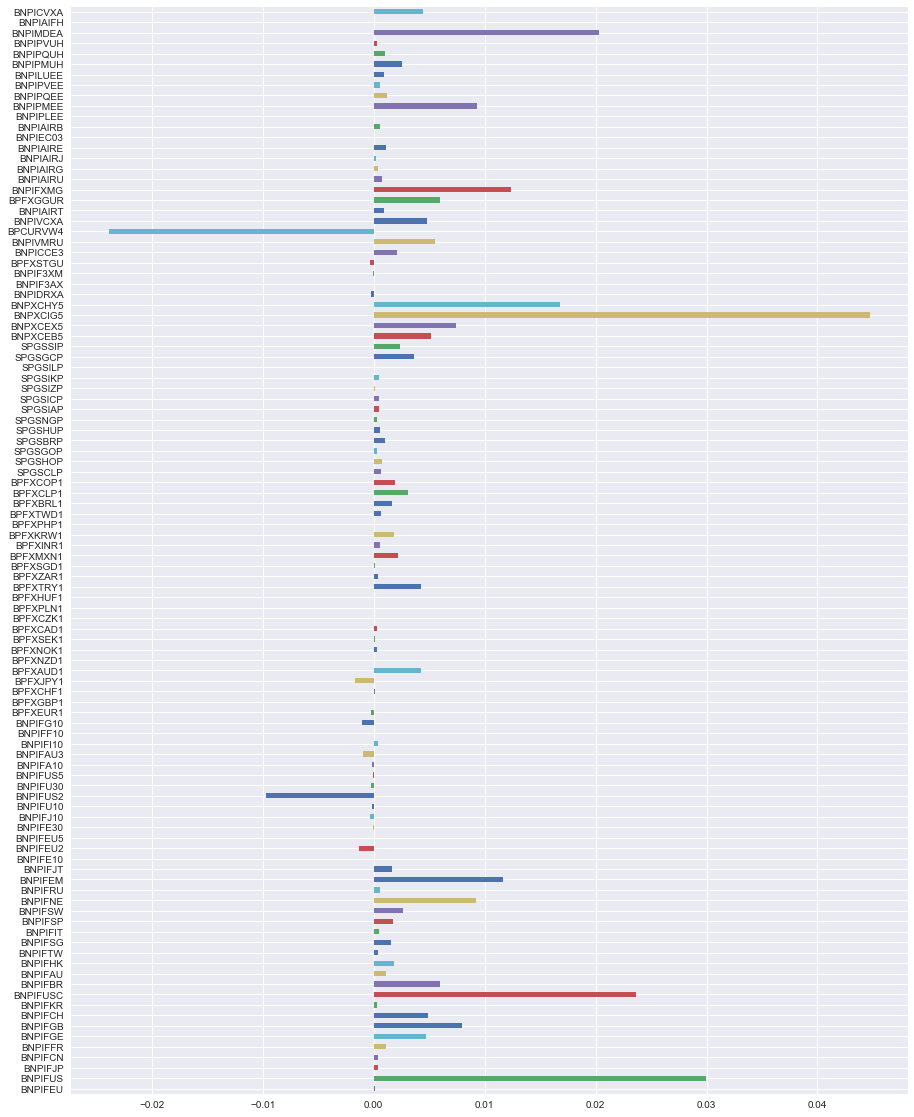

In [38]:
(df_weight_aic).mean(axis=0).plot(kind='barh', figsize=(15,20))

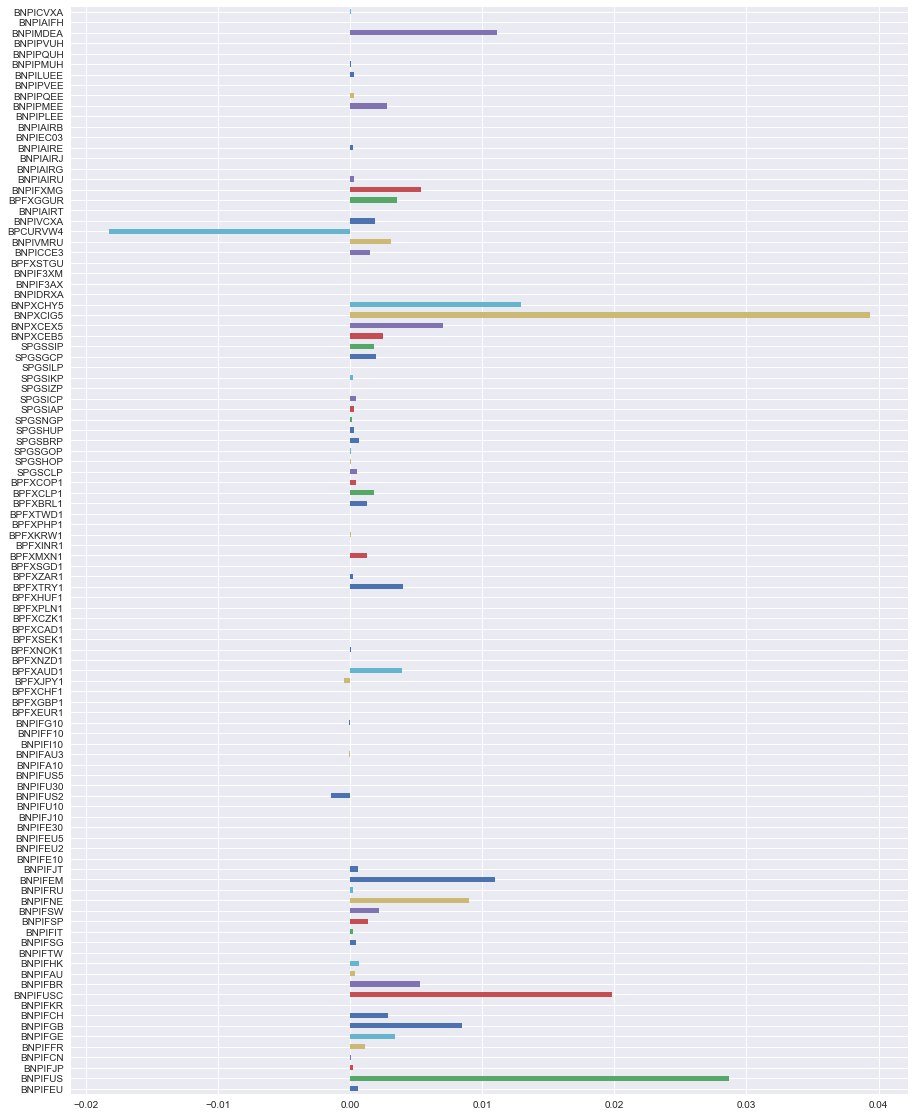

In [39]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

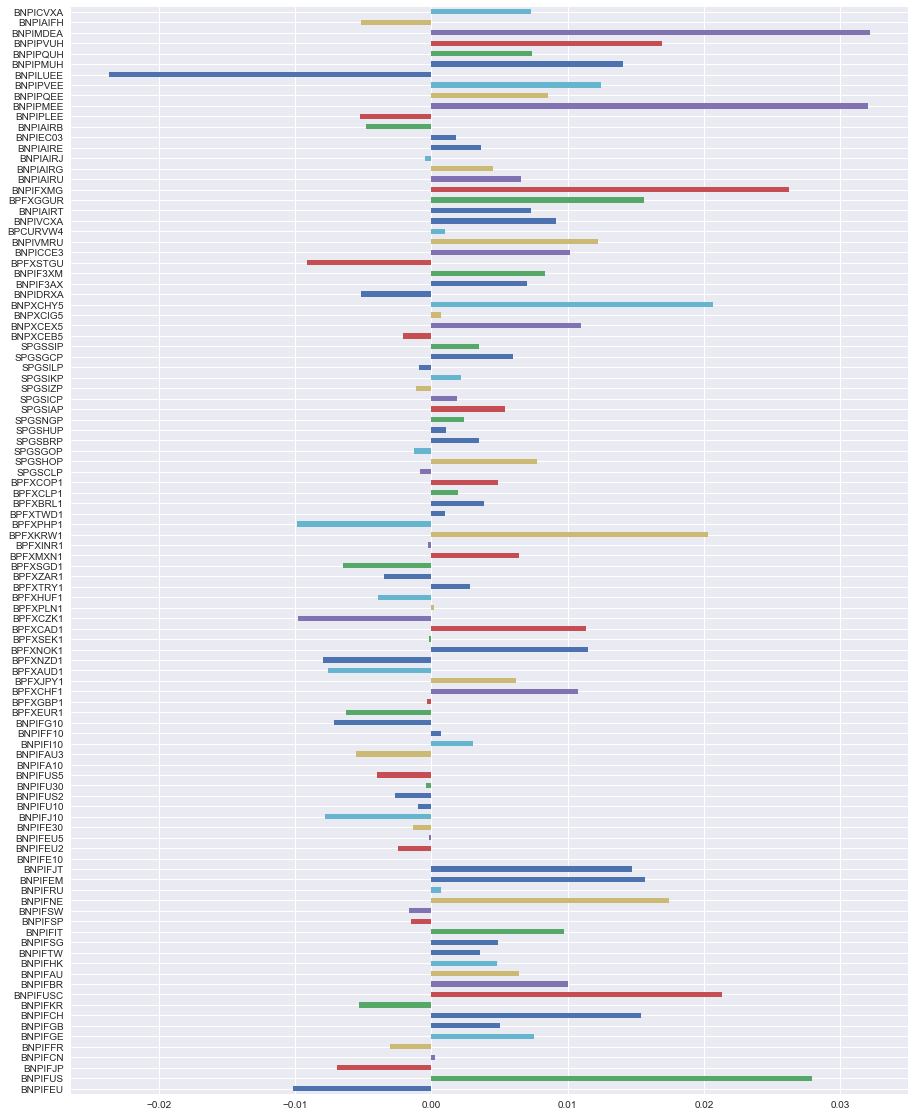

In [40]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

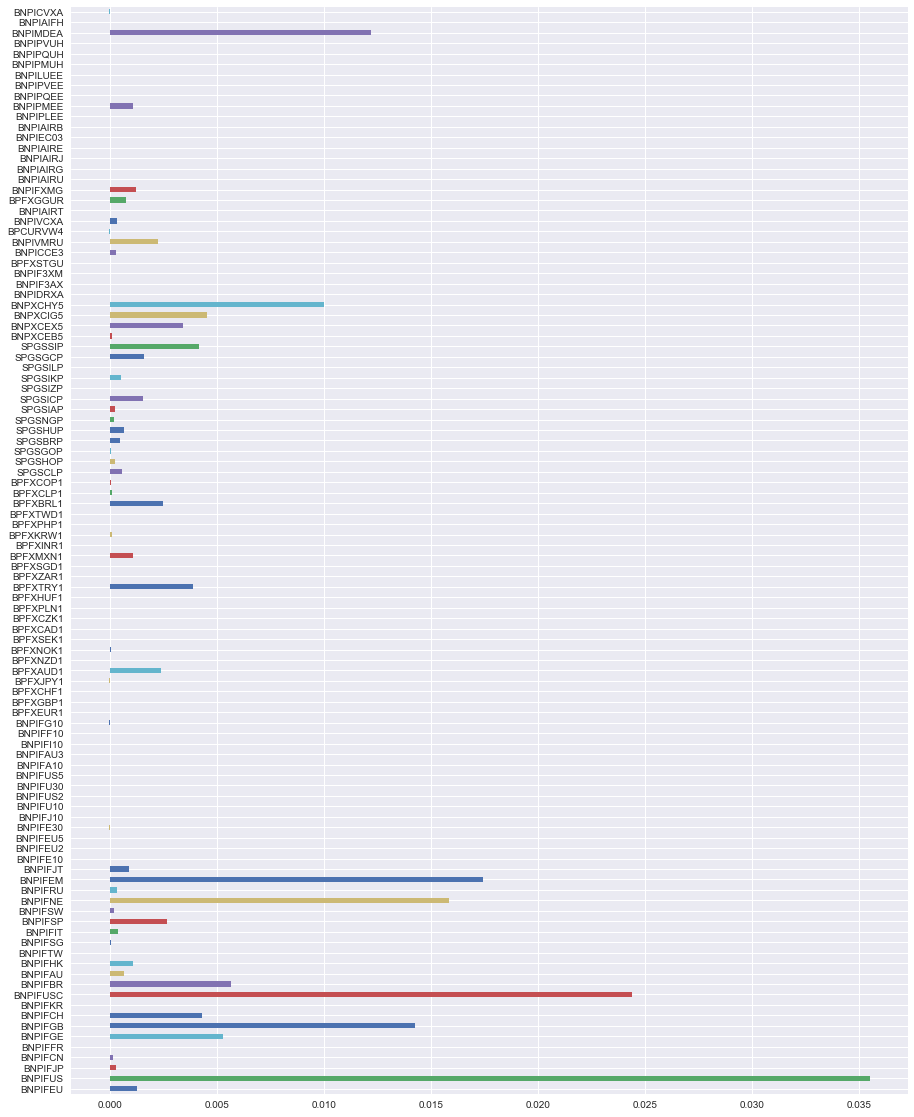

In [41]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

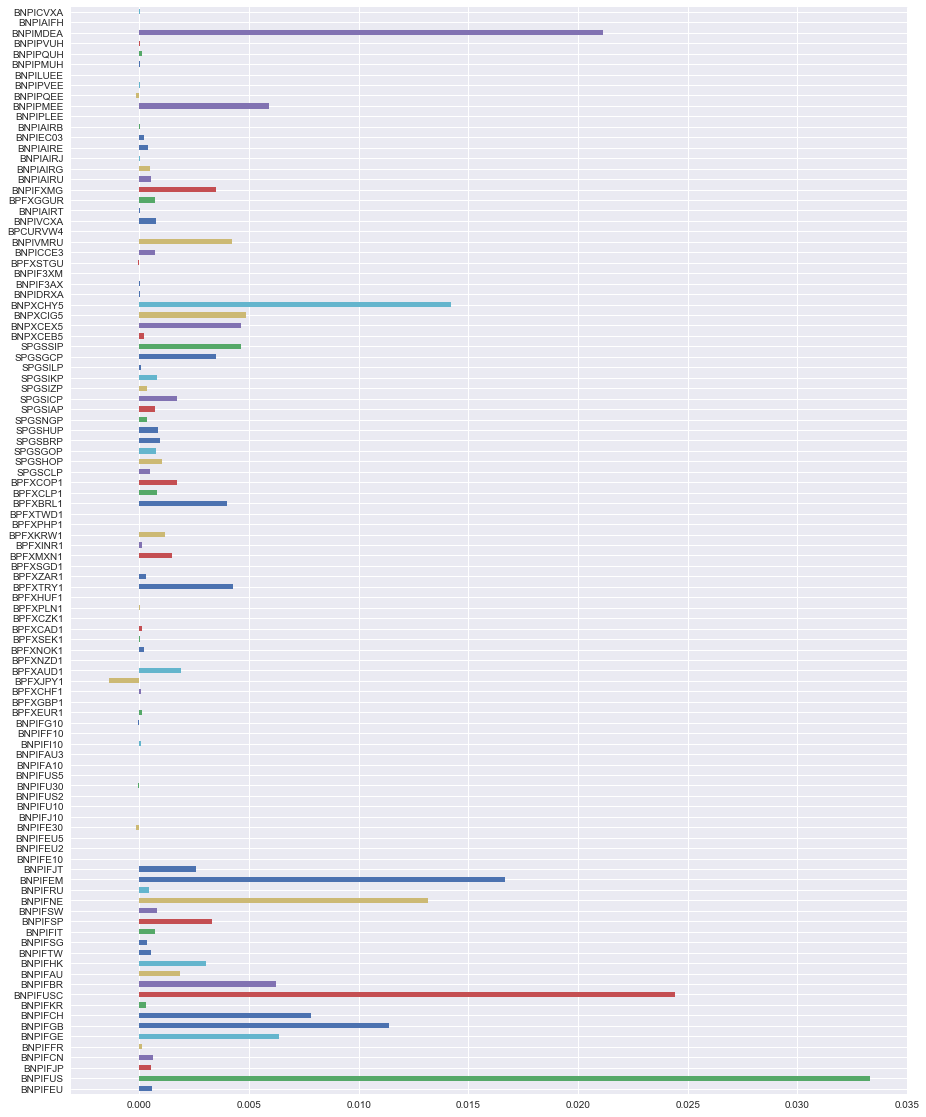

In [42]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [43]:
limit = 60
df_autocorr = pd.DataFrame(data=[df_res.drop(["Lasso AIC","Lasso BIC"],axis=1)\
                                 .pct_change().apply(lambda col : col.autocorr(lag=i)) for i in range(1,limit)])
df_autocorr[r"$2/\sqrt{n}$"] = [2/np.sqrt(len(df_res)-i) for i in range(1,limit)]
df_autocorr[r"$-2/\sqrt{n}$"] = [-2/np.sqrt(len(df_res)-i) for i in range(1,limit)]

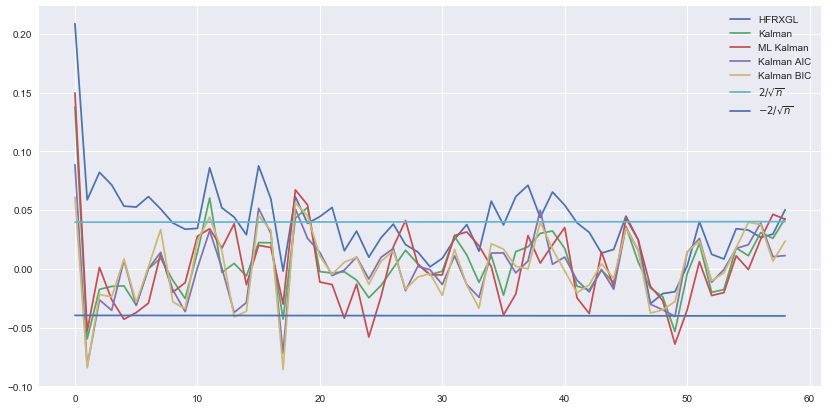

In [44]:
df_autocorr.plot(figsize=(14,7))

In [45]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.2086687261801249

In [46]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.1376196966141262

In [47]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

0.06100624986304337

In [48]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

0.08853884649470938

In [49]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.06865166511097323